In [64]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,6e18918b-4ab5-4534-a245-8c68b2e5232b,mixed_function,Transformer,"function_types=['linear', 'quadratic', 'neural...",-1,-1,20,12,8,mixed_function_all_types


In [67]:
task = "mixed_function"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "ee916842-66f0-4652-8878-6aad0813b2a1"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

mixed_function_all_types 6e18918b-4ab5-4534-a245-8c68b2e5232b


100%|██████████| 6/6 [00:00<00:00, 32472.03it/s]


=== Mixed Function Evaluation Results ===

LINEAR Metrics:
  Model: gpt2_embd=256_layer=12_head=8
    Mean Error: [17.236248016357422, 19.842632293701172, 19.74319076538086, 17.88824462890625, 18.49454116821289, 19.436059951782227, 17.573841094970703, 18.801471710205078, 19.732284545898438, 19.167638778686523, 18.383554458618164, 19.66156768798828, 17.591289520263672, 20.07867431640625, 17.729446411132812, 19.28171157836914, 18.53596305847168, 19.84885025024414, 19.05222511291504, 19.427570343017578, 19.637744903564453, 20.28992462158203, 20.458995819091797, 19.542673110961914, 19.6545352935791, 20.00641441345215, 19.410533905029297, 20.3030948638916, 19.66180419921875, 19.99942398071289, 19.55751609802246, 18.21204948425293, 17.42983055114746, 19.55415916442871, 19.24489402770996, 19.260074615478516, 18.71993637084961, 20.016664505004883, 18.23739242553711, 18.73305892944336, 18.154041290283203]
    Std Dev: [23.887479782104492, 28.441051483154297, 28.82021141052246, 25.8579750061035

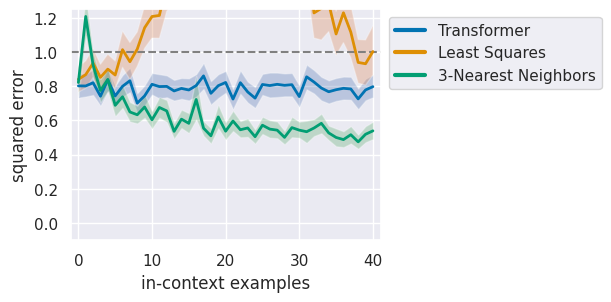

In [68]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

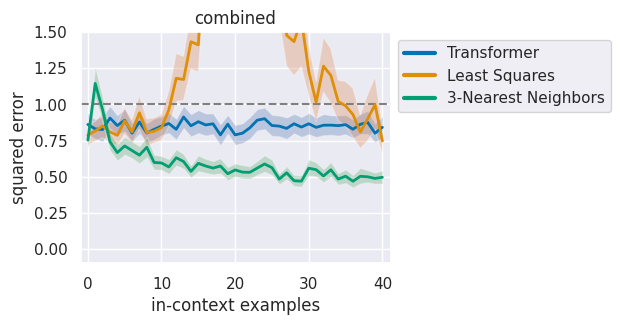

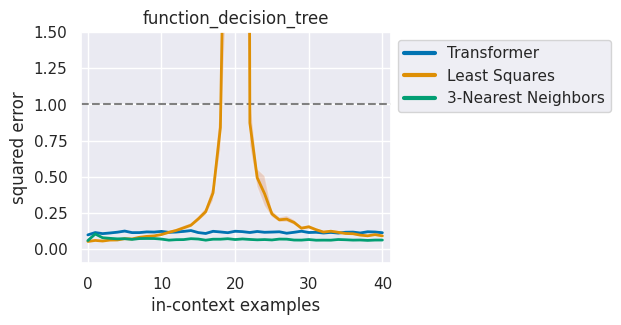

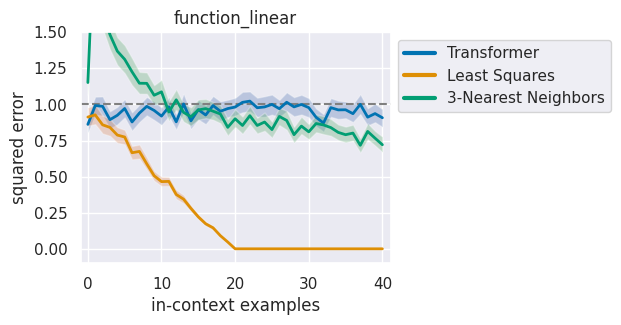

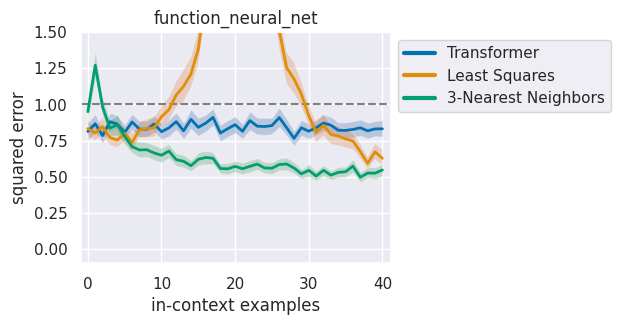

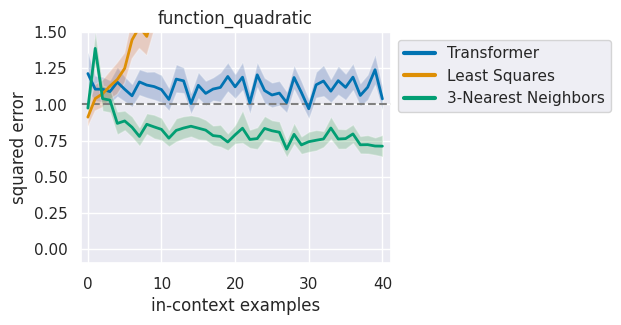

In [69]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue

    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)

    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [70]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [71]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [72]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [73]:
with torch.no_grad():
    pred = model(xs, ys)

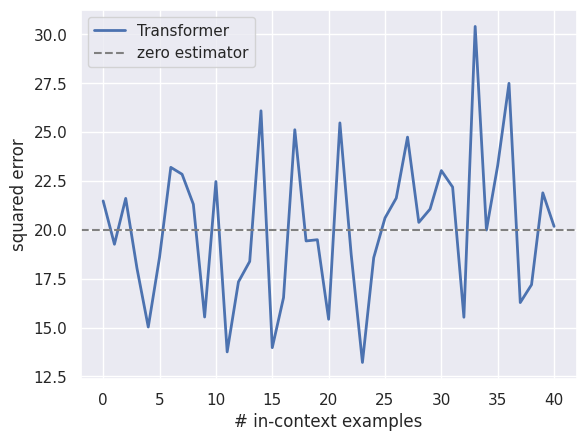

In [75]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "mixed_function": n_dims,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [39]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

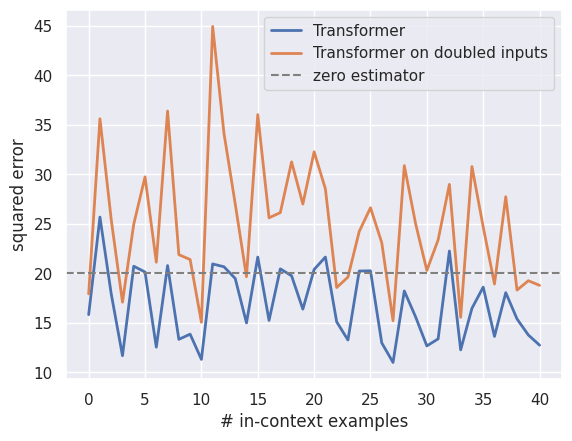

In [40]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.